## Imports and setup

In [182]:
# Imports:
import pathlib
import subprocess
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pandas as pd
import dask.array as da
from tqdm.auto import tqdm

In [25]:
# Define paths

propPath = pathlib.Path('/nsls2/data/sst/proposals/2023-3/pass-313412')
outPath = propPath.joinpath('processed_data')
plotsPath = outPath.joinpath('nexafs_plots', 'material_optical_constants')
zarrsPath = outPath.joinpath('zarrs')

In [3]:
# Define functions

def binary_contrast(n1, n2=None):
    if n2 is None:
        #second component is vacuum
        n2 = xr.zeros_like(n1)
    else:
        #second is interpolated to match the energy array of the first component.  
        n2 = n2.interp(energy=n1.energy)
    return n1.energy**4 * ((n1.delta-n2.delta)**2 + (n1.beta-n2.beta)**2)

## Load optical constants dataset

In [85]:
oc_DS = xr.open_zarr(zarrsPath.joinpath(f'material_optical_constants.zarr')).sortby('theta')

# Compute any dask coordiantes
for coord_name, coord_data in oc_DS.coords.items():
    if isinstance(coord_data.data, da.Array):
        oc_DS.coords[coord_name] = coord_data.compute()
        
oc_DS

<xarray.Dataset>
Dimensions:          (sample_name: 5, theta: 100, energy: 3000)
Coordinates:
    cos_sq_theta     (sample_name, theta) float64 1.232 1.217 ... -0.0615
  * energy           (energy) float64 250.0 250.0 250.1 ... 349.9 350.0 350.0
  * sample_name      (sample_name) <U12 'PM6_CBCN_rot' 'Y6BO_CF' ... 'Y7_CB'
  * theta            (theta) float64 0.0 0.9091 1.818 2.727 ... 88.18 89.09 90.0
Data variables:
    beta             (sample_name, theta, energy) float64 dask.array<chunksize=(2, 25, 1500), meta=np.ndarray>
    delta            (sample_name, theta, energy) float64 dask.array<chunksize=(2, 25, 1500), meta=np.ndarray>
    vacuum_contrast  (sample_name, energy, theta) float64 dask.array<chunksize=(2, 750, 50), meta=np.ndarray>

## Material optical constants and vacuum contrast manifolds

In [155]:
colors = plt.cm.plasma_r(np.linspace(0.05,1,len(oc_DS.theta)))
# sample_name = str(oc_DS.sample_name.values)

for sample_name in tqdm(oc_DS.sample_name.values):
    samp_oc_DS = oc_DS.sel(sample_name=sample_name)
    
    for data_var in ['delta', 'beta', 'vacuum_contrast']:
        
        yscale = 'log' if data_var == 'vacuum_contrast' else 'linear'
        ylabel = 'Contrast [arb. units]' if data_var == 'vacuum_contrast' else f'$\{data_var}$ [arb. units]'
        
        for energy_slice in [slice(282,290), slice(282,320), slice(None,None)]:
            fig, ax = plt.subplots(figsize=(5.5,3.5), dpi=120)
            for i, theta_val in enumerate(oc_DS.theta.values):
                samp_oc_DS[data_var].sel(theta=theta_val, energy=energy_slice).plot(ax=ax, color=colors[i])

            samp_oc_DS[data_var].sel(theta=0, method='nearest').sel(energy=energy_slice).plot(ax=ax, color=colors[0], label='extraordinary ($\\theta=0°$)')
            samp_oc_DS[data_var].sel(theta=90, method='nearest').sel(energy=energy_slice).plot(ax=ax, color=colors[-1], label='ordinary ($\\theta=90°$)')
            samp_oc_DS[data_var].sel(theta=55, method='nearest').sel(energy=energy_slice).plot(ax=ax, color='paleturquoise', label='magic (composition)')
            ax.set(title=f'Face-on extrapolated {data_var}: {sample_name}', yscale=yscale, ylabel=ylabel, xlabel='Photon Energy [eV]')
            ax.grid(axis='x')
            ax.legend(title='Orientation', loc='lower right')
            plt.subplots_adjust(bottom=0.2, left=0.2)
            
            
            fig.savefig(plotsPath.joinpath('single', f'{sample_name}_energy{energy_slice.start}-{energy_slice.stop}_{data_var}.png'), dpi=120)

            # plt.show()
            plt.close('all')

  0%|          | 0/5 [00:00<?, ?it/s]

## Binary Contrast Manifolds

In [194]:
colors = plt.cm.plasma_r(np.linspace(0.05,1,len(oc_DS.theta)))
pm6_oc_DS = oc_DS.sel(sample_name='PM6_CBCN_rot', drop=True)

sample_names = sorted((set(oc_DS.sample_name.values) - set(['PM6_CBCN_rot'])))
for sample_name in tqdm(sample_names):
    for samp_theta in [55]:
        samp_oc_DS = oc_DS.sel(sample_name=sample_name, drop=True).sel(theta=samp_theta, method='nearest', drop=True)

        for energy_slice in [slice(282,290), slice(282,320), slice(None,None)]:
            fig, ax = plt.subplots(figsize=(6,4), dpi=120)
            fig.suptitle(f'Face-on extrapolated binary contrast: PM6:{sample_name}', x=0.55)
            for i, theta_val in enumerate(oc_DS.theta.values):
                binary_contrast(pm6_oc_DS, samp_oc_DS).sel(theta=theta_val, energy=energy_slice).plot(ax=ax, color=colors[i])

            binary_contrast(pm6_oc_DS, samp_oc_DS).sel(theta=55, method='nearest').sel(energy=energy_slice).plot(ax=ax, color='paleturquoise', label='PM6 magic ($\\theta=55°$)')
            binary_contrast(pm6_oc_DS, samp_oc_DS).sel(theta=90, method='nearest').sel(energy=energy_slice).plot(ax=ax, color=colors[-1], label='PM6 ordinary ($\\theta=90°$)')
            binary_contrast(pm6_oc_DS, samp_oc_DS).sel(theta=0, method='nearest').sel(energy=energy_slice).plot(ax=ax, color=colors[0], label='PM6 extraordinary ($\\theta=0°$)')
            ax.set(title=f'Full PM6 orientation manifold, {sample_name} $\\theta$ = {samp_theta}°', 
                   yscale=yscale, ylabel=ylabel, xlabel='Photon Energy [eV]')
            ax.set_ylim(bottom=1e1, top=7e4)
            ax.grid(axis='x')
            ax.legend(title='Orientation', loc='lower right')
            plt.subplots_adjust(bottom=0.2, left=0.2, top=0.87)


            fig.savefig(plotsPath.joinpath('binary', f'PM6-{sample_name}_energy{energy_slice.start}-{energy_slice.stop}.png'), dpi=120)

            # plt.show()
            plt.close('all')

  0%|          | 0/4 [00:00<?, ?it/s]

In [192]:
colors = plt.cm.plasma_r(np.linspace(0.05,1,len(oc_DS.theta)))
pm6_oc_DS = oc_DS.sel(sample_name='PM6_CBCN_rot', drop=True)

sample_names = sorted((set(oc_DS.sample_name.values) - set(['PM6_CBCN_rot'])))
for sample_name in tqdm(sample_names):
    for energy_slice in [slice(282,290), slice(282,320), slice(None,None)]:
        # energy_slice = slice(282,290)
        output_path = plotsPath.joinpath('binary', f'PM6-{sample_name}_energy{energy_slice.start}-{energy_slice.stop}.mp4')

        # FFmpeg command. This is set up to accept data from the pipe and use it as input, with PNG format.
        # It will then output an H.264 encoded MP4 video.
        cmd = [
            'ffmpeg',
            '-y',  # Overwrite output file if it exists
            '-f', 'image2pipe',
            '-vcodec', 'png',
            '-r', '20',  # Frame rate
            '-i', '-',  # The input comes from a pipe
            '-vcodec', 'libx264',
            '-pix_fmt', 'yuv420p',
            '-crf', '17',  # Set the quality (lower is better, 17 is often considered visually lossless)
            str(output_path)
        ]

        # Start the subprocess
        proc = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)    

        for samp_theta in tqdm(np.linspace(0, 90, 50), desc=f'Making movie for PM6:{sample_name}'):
            samp_oc_DS = oc_DS.sel(sample_name=sample_name, drop=True).sel(theta=samp_theta, method='nearest', drop=True)

            # Plot
            fig, ax = plt.subplots(figsize=(6,4), dpi=120)
            fig.suptitle(f'Face-on extrapolated binary contrast: PM6:{sample_name}', x=0.55)
            for i, theta_val in enumerate(oc_DS.theta.values):
                binary_contrast(pm6_oc_DS, samp_oc_DS).sel(theta=theta_val, energy=energy_slice).plot(ax=ax, color=colors[i])

            binary_contrast(pm6_oc_DS, samp_oc_DS).sel(theta=55, method='nearest').sel(energy=energy_slice).plot(ax=ax, color='paleturquoise', label='PM6 magic ($\\theta=55°$)')
            binary_contrast(pm6_oc_DS, samp_oc_DS).sel(theta=90, method='nearest').sel(energy=energy_slice).plot(ax=ax, color=colors[-1], label='PM6 ordinary ($\\theta=90°$)')
            binary_contrast(pm6_oc_DS, samp_oc_DS).sel(theta=0, method='nearest').sel(energy=energy_slice).plot(ax=ax, color=colors[0], label='PM6 extraordinary ($\\theta=0°$)')
            ax.set(title=f'Full PM6 orientation manifold, {sample_name} $\\theta$ = {np.round(samp_theta, 1)}°', 
                   yscale=yscale, ylabel=ylabel, xlabel='Photon Energy [eV]')
            ax.set_ylim(bottom=1e1, top=7e4)
            ax.grid(axis='x')
            ax.legend(title='Orientation', loc='lower right')
            plt.subplots_adjust(bottom=0.2, left=0.2, top=0.87)

            # Save figure to a PNG buffer
            buf = io.BytesIO()
            ax.figure.savefig(buf, format='png')
            buf.seek(0)

            # Write the PNG buffer data to the process
            proc.stdin.write(buf.getvalue())
            plt.close('all')

        # Finish the subprocess
        out, err = proc.communicate()
        if proc.returncode != 0:
            print(f"Error: {err}")            

  0%|          | 0/4 [00:00<?, ?it/s]

Making movie for PM6:Y6BO_CF:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y6BO_CF:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y6BO_CF:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y6_CF:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y6_CF:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y6_CF:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y7BO_CB:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y7BO_CB:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y7BO_CB:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y7_CB:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y7_CB:   0%|          | 0/50 [00:00<?, ?it/s]

Making movie for PM6:Y7_CB:   0%|          | 0/50 [00:00<?, ?it/s]

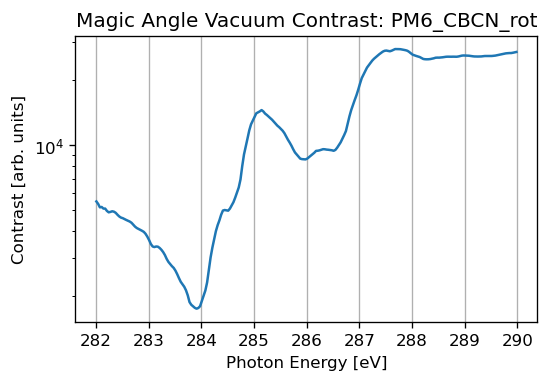

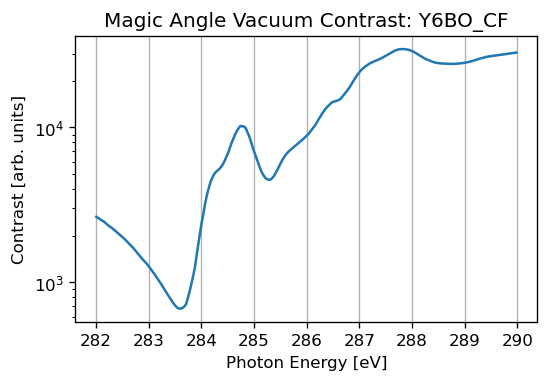

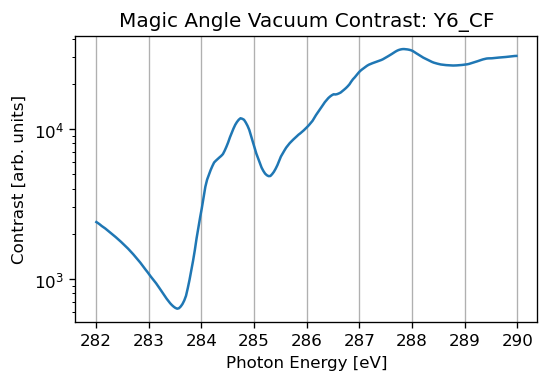

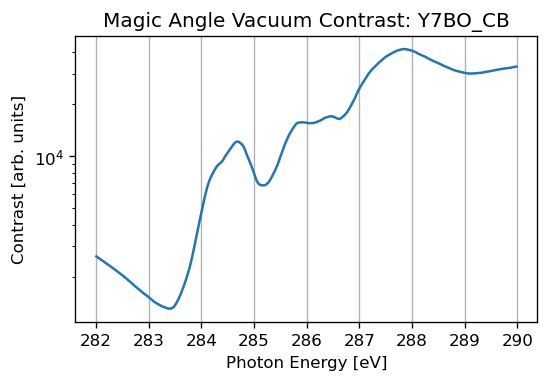

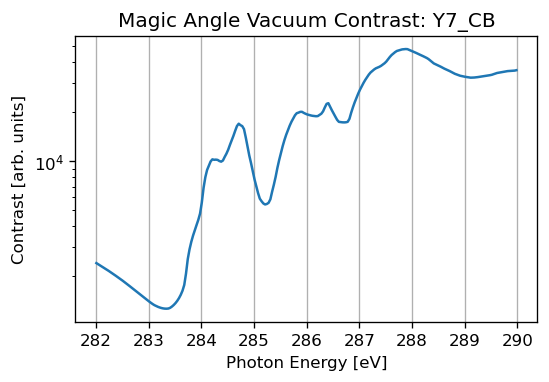

In [87]:
for sample_name in oc_DS.sample_name.values:
    fig, ax = plt.subplots(figsize=(5.5, 3.5), dpi=120)
    oc_DS.sel(theta=55, method='nearest').sel(sample_name=sample_name, energy=slice(282,290))['vacuum_contrast'].plot(ax=ax, yscale='log')
    
    ax.set(title=f'Magic Angle Vacuum Contrast: {sample_name}', ylabel='Contrast [arb. units]', xlabel='Photon Energy [eV]')
    ax.grid(axis='x')    
    plt.subplots_adjust(left=0.2, bottom=0.2)
    
    # fig.savefig(plotsPath.joinpath(f'{sample_name}_magic_vacuum_contrast.png'), dpi=120)
    plt.show()
    plt.close('all')

## Orientation manifold vacuum contrasts

In [193]:
# # Example: Assuming you want to plot for a specific 'sample_name'
# sample = 'Y6_CF'  # Replace with the actual sample name you want to plot

# # Extract the data for the lines
# theta0_line = oc_DS['vacuum_contrast'].sel(sample_name=sample, theta=0)
# theta55_line = oc_DS['vacuum_contrast'].sel(sample_name=sample, theta=55)
# theta90_line = oc_DS['vacuum_contrast'].sel(sample_name=sample, theta=90)
# energy = oc_DS['energy'].data

# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(5.5,3.5), dpi=120)

# # Plot the lines
# ax.plot(energy, theta0_line, label='Theta=0')
# ax.plot(energy, theta55_line, label='Theta=55', linewidth=2)  # Make Theta=55 line stand out
# ax.plot(energy, theta90_line, label='Theta=90')

# # Shade the area between Theta=0 and Theta=90
# ax.fill_between(energy, theta0_line, theta90_line, color='grey', alpha=0.5)

# # # Shade the area between Theta=55 and Theta=90
# # ax.fill_between(energy, theta55_line, theta90_line, color='grey', alpha=0.5)

# # Adding labels and legend
# ax.set(xlim=(282,290), yscale='log', xlabel='Photon Energy [eV]', ylabel='Contrast [arb. units]')
# ax.legend(loc='lower right')

# # Show the plot
# plt.show()
